# Inference with Synthetic Data

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import matplotlib.pyplot as plt

from src import Flag, AbstractTask, AbstractFlag, Pipeline
import numpy as np

from matplotlib.ticker import PercentFormatter
from src import PlotPipelineFactory
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Edited the file path by @Keisuke

dataPath = r"../data/csv/"
picklePath = r"../pickle_objects/modeling_pipeline/"
plotPath = r"../../evaluation/confidence_level/stefan/"
modelPath = r"../pickle_objects/models_and_scalers/"


In [3]:
import pickle
with open(picklePath + 'Modeling Pipeline.pickle', 'rb') as f:
    ModelingPipeline = pickle.load(f)

ModelingPipeline.print(priority = True, flags = True)

Modeling Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		20 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		30 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		40 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		50 Fill Numeric NA with 0
		60 Fill String NA with None
		70 Datetime conversion
		80 Clean PDU
		90 Order DataFrame
		100 Convert object type to string
	20 Dummy Processing: Dummy Processing
		10 Dummies Channel
		20 Dummies AD Type
		30 Dummies Company
		40 Dummies UUID
		50 Dummies PDU Type
		60 Dummies Continuity Type
		70 Dummies SmartTag Type
	30 Labeling: Labeling
		10 Labeling auto: Labeling auto
			Label FindMy Tracker and iDevice: Label FindMy Tracker and iDevice
			Label Tile and

In [4]:
with open(picklePath + 'Pre Processing.pickle', 'rb') as f:
    flag_preProcessing = pickle.load(f)

with open(picklePath +  'Modeling.pickle', 'rb') as f:
    flag_modeling = pickle.load(f)

with open(picklePath + 'Dummy Processing.pickle', 'rb') as f:
    flag_dummy= pickle.load(f)

with open(picklePath + 'Rate Modeling.pickle', 'rb') as f:
    flag_Rate_Modeling = pickle.load(f)

In [5]:
def filesToDataFrame(filesDict: dict[str:AbstractFlag], filePath:str = dataPath, config:AbstractTask = ModelingPipeline) -> pd.DataFrame:
    dataset = pd.DataFrame()

    for f in filesDict.keys():
        new_dataset = Pipeline().setPath(filePath + f).setTask(config).loadData().run(flag=filesDict[f])
        dataset = pd.concat([dataset, new_dataset])
        
    dataset.reset_index(drop = True, inplace = True)

    return dataset

def Inference(dataset: pd.DataFrame, modelName: str, scalerName: str, path:str = modelPath):
    with open(path + modelName + ".pickle", 'rb') as f:
        model = pickle.load(f)

    with (open(path + scalerName + ".pickle", 'rb') as f):
        scaler = pickle.load(f)
        
    sourceData = dataset[['Source','Time']]
    dataset = dataset.drop(columns=['Source','Time'], axis = 1)

    X_scaled = scaler.transform(dataset.copy(deep=True).to_numpy())
    
    y_pred = model.predict_proba(X_scaled)
    y_pred = pd.DataFrame(data=y_pred, columns=model.classes_)
    
    y_pred = y_pred.round(4) * 100
    y_pred = pd.concat([sourceData, y_pred], axis=1)
    y_pred['Label'] = model.predict(X_scaled)
    y_pred['Label'] = y_pred['Label'].astype("string")

    y_pred['Max Proba'] = y_pred.iloc[:, 2:-1].max(axis = 1)
    
    return y_pred, list(model.classes_)

In [6]:
# Changed the model and scaler names by @Keisuke

Modeling_Flag = Flag("Modeling", parents=[flag_modeling, flag_dummy, flag_preProcessing])

files = {"Inference/Bahnhof_V2.csv": Modeling_Flag,
         }

data = filesToDataFrame(files)

y_pred, labels = Inference(data, modelName = 'With synthetic Data generated by Stefan model', scalerName='With synthetic Data generated by Stefan scaler')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490031 entries, 0 to 490030
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Time                                        490031 non-null  datetime64[ns]
 1   Source                                      490031 non-null  string        
 2   Length Packet                               490031 non-null  int64         
 3   Length Header                               490031 non-null  int64         
 4   Length MS Data                              490031 non-null  int64         
 5   Length Service Data                         490031 non-null  int64         
 6   CH 37                                       490031 non-null  int64         
 7   CH 38                                       490031 non-null  int64         
 8   CH 39                                       490031 non-null  int64        

In [8]:
y_pred.head()

,Source,Time,FindMy Tracker (lost),FindMy Tracker (nearby),FindMy Tracker (unpaired),SmartTag (lost),SmartTag (nearby),Tile (lost),iDevice,iDevice FindMy offline,iDevice FindMy online,other Device,Label,Max Proba
0,d5:b6:19:29:fb:2a,2024-04-25 15:42:32.297384024,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,100.00,0.00,iDevice FindMy online,100.00
1,d5:b6:19:29:fb:2a,2024-04-25 15:42:32.298383951,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,100.00,0.00,iDevice FindMy online,100.00
2,d5:b6:19:29:fb:2a,2024-04-25 15:42:32.299381971,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,99.99,0.00,iDevice FindMy online,99.99
3,7a:2d:7c:6b:c0:82,2024-04-25 15:42:32.300105095,0.00,0.01,0.01,0.0,21.73,0.00,0.02,0.0,0.02,78.20,other Device,78.20
4,de:c0:00:81:de:a0,2024-04-25 15:42:32.303154945,0.07,1.31,0.04,0.0,0.91,0.01,0.01,0.0,0.00,97.66,other Device,97.66


In [23]:
# Changed the plot title and the file type from png to pdf by @Keisuke
def plotLorenz(dataToPlot):
    title_suffix = str(dataToPlot['Label'].iloc[0])
    title = 'Confidence: with Synthetic Data Generated by Stefan - ' + title_suffix

    dataToPlot = dataToPlot.sort_values(by = 'Max Proba', ascending = False)
    dataToPlot['Percentile'] = np.arange(0, dataToPlot.shape[0]) / (dataToPlot.shape[0] - 1)

    plt.figure(figsize = (16, 9), dpi = 100)
    plt.plot(dataToPlot['Percentile'], dataToPlot['Max Proba'] / 100, linewidth=10)
    plt.xlim(0)
    plt.ylim(bottom = 0, top = 1.1)
    plt.title(title, fontsize = 20)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
  
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylabel("Confidence", fontsize = 15)
    plt.xlabel("% of Packets", fontsize = 15)
    plt.tight_layout()
    plt.savefig(plotPath + title + '.pdf', dpi = 300)
    plt.show()

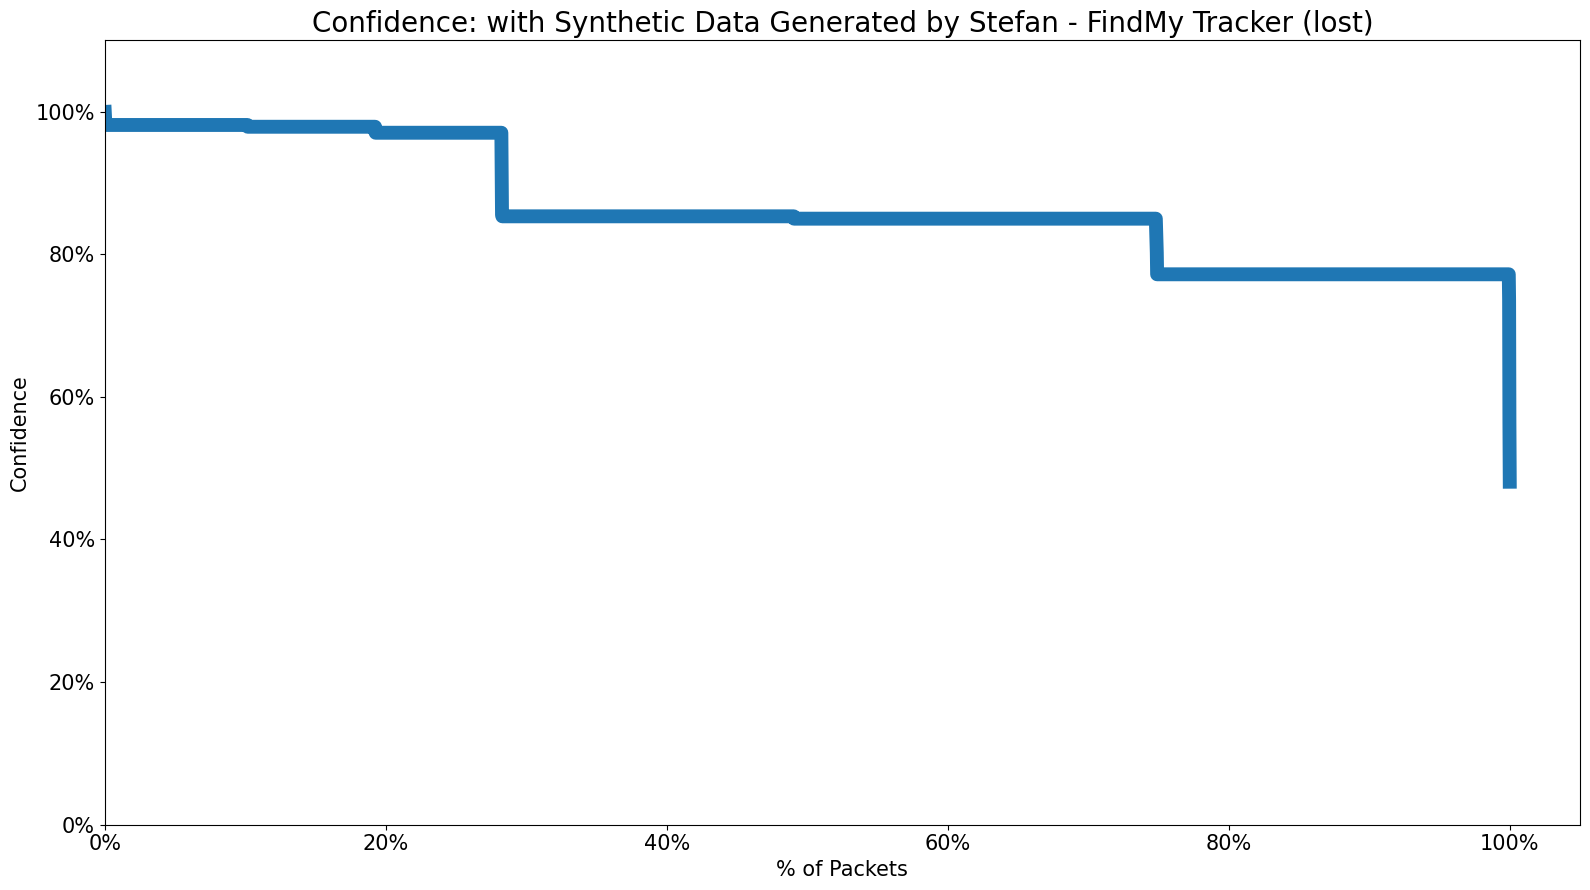

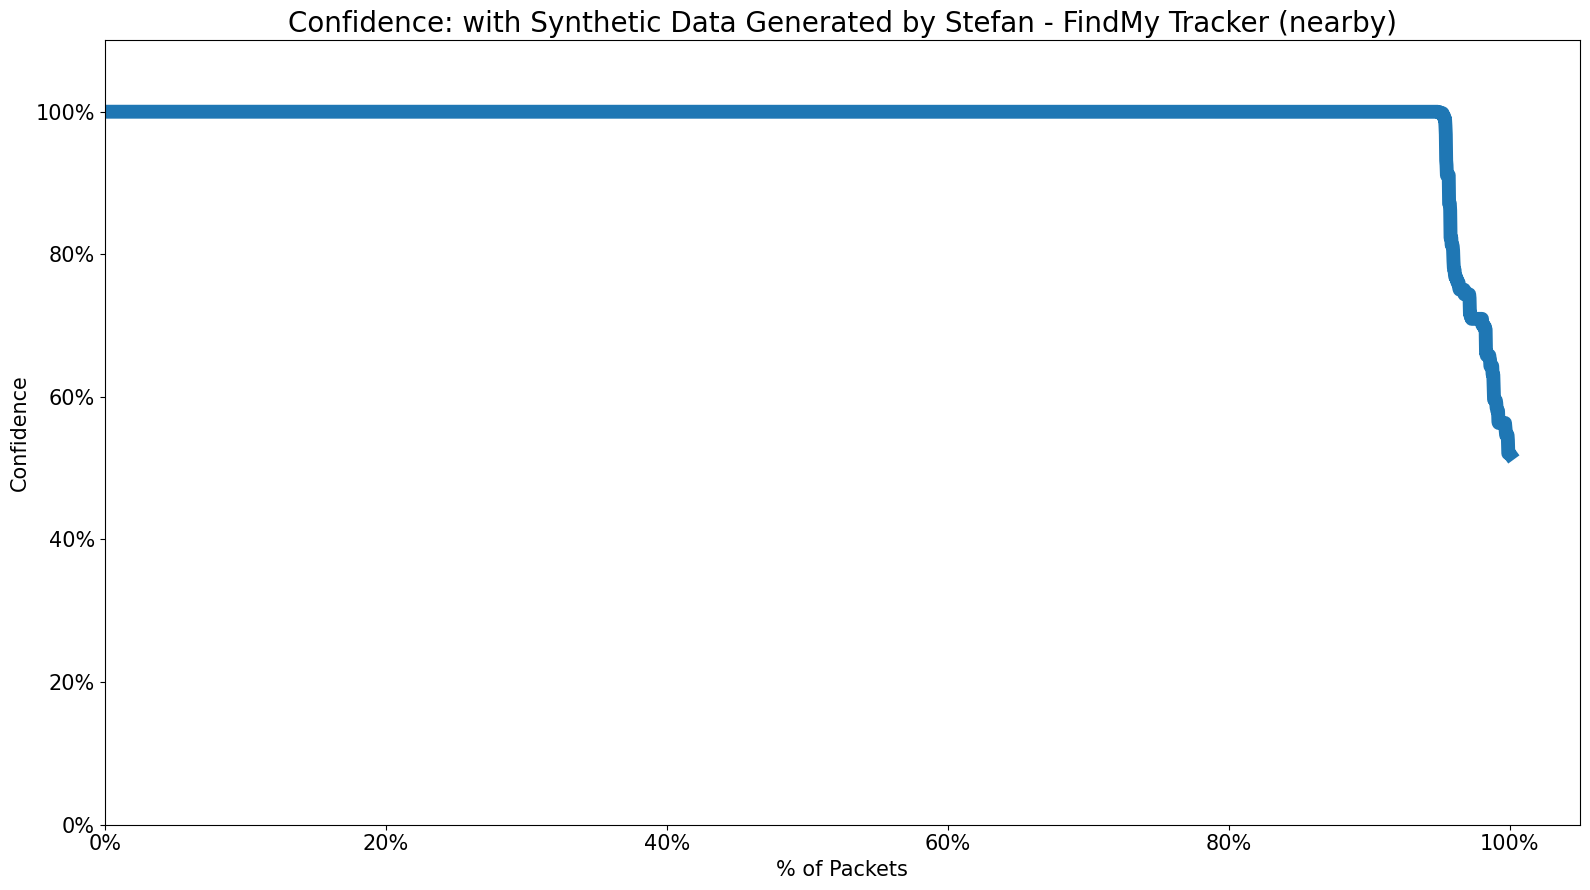

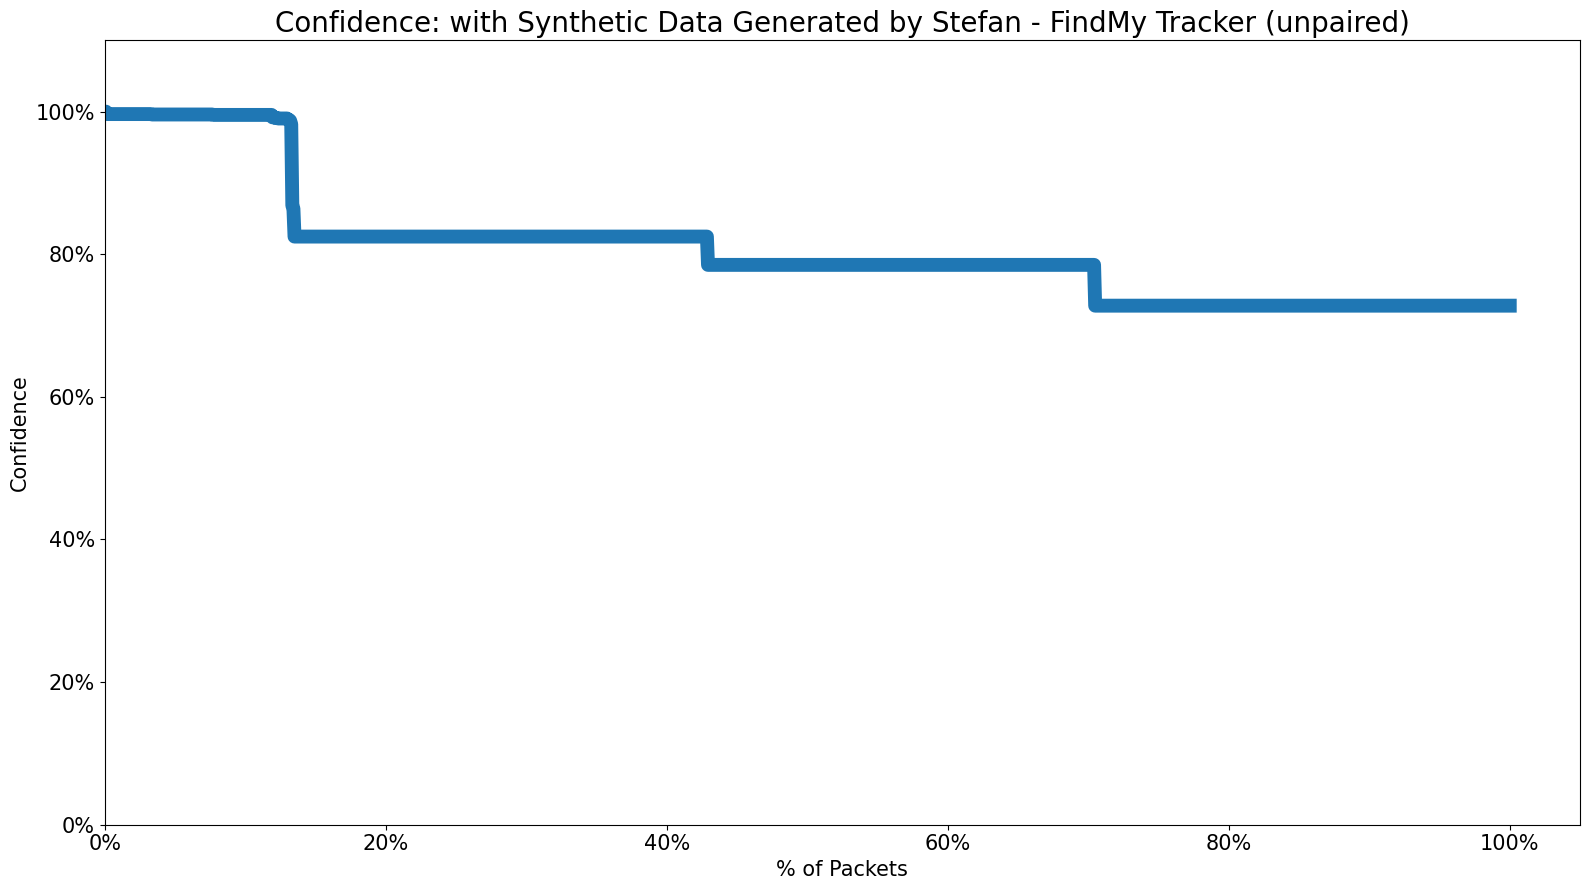

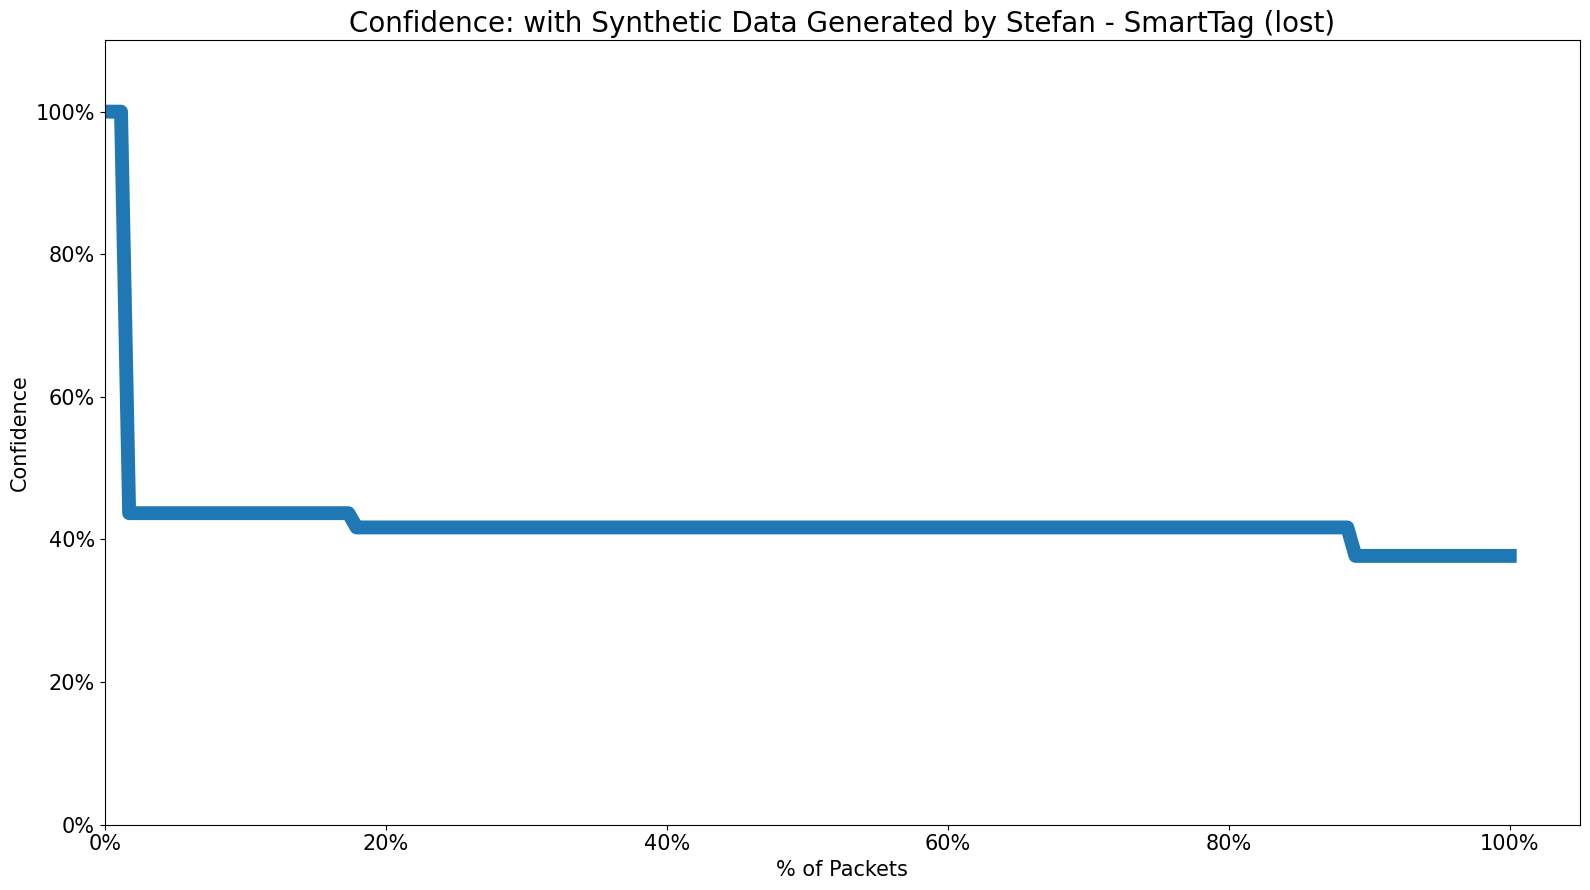

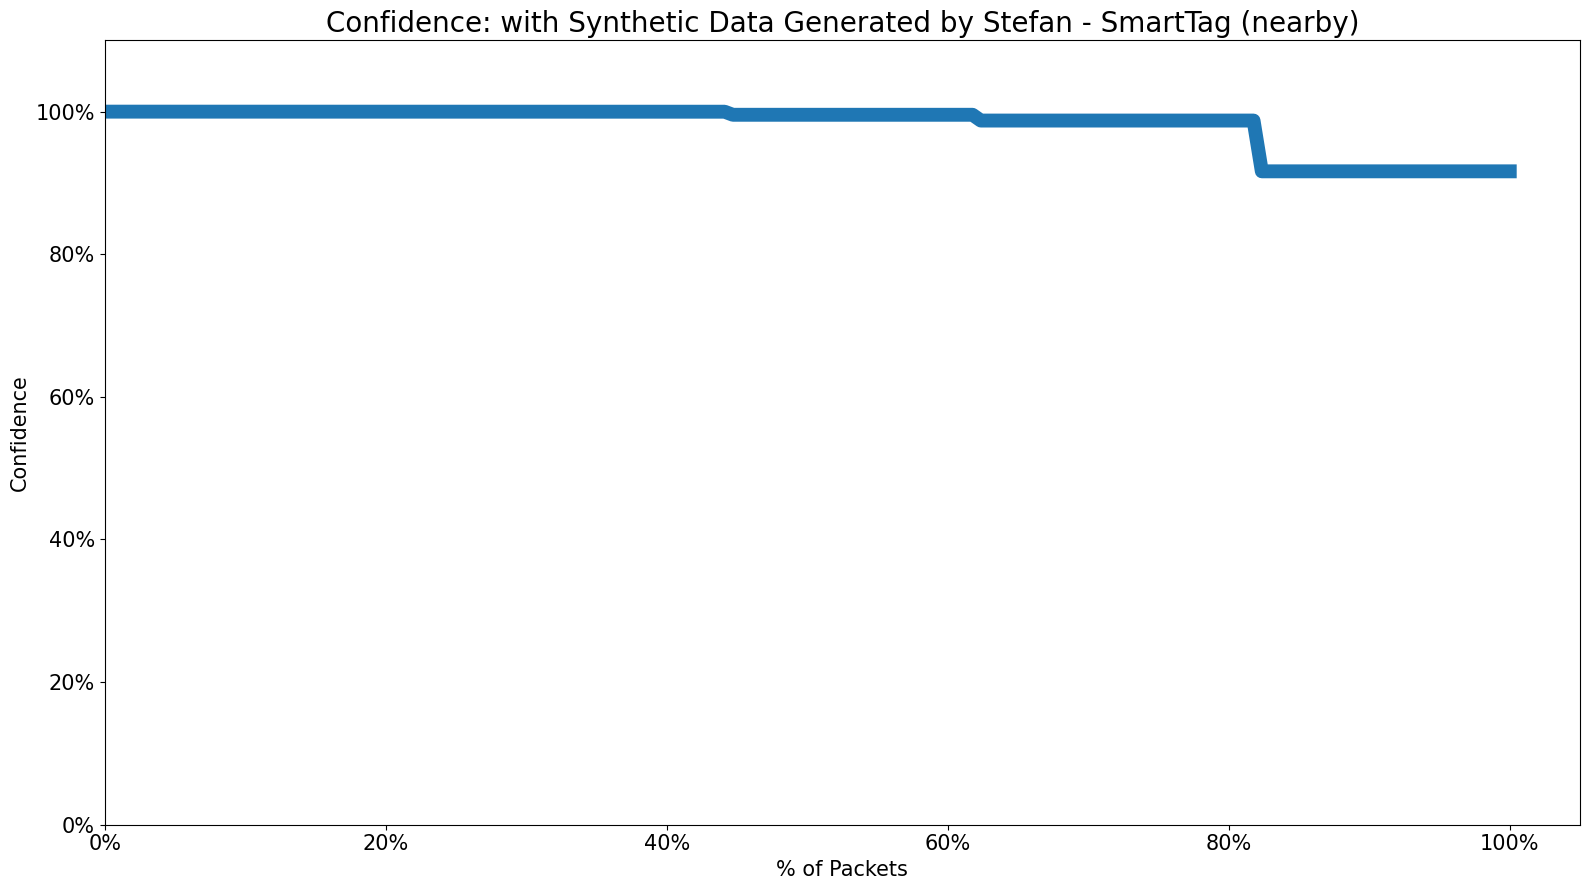

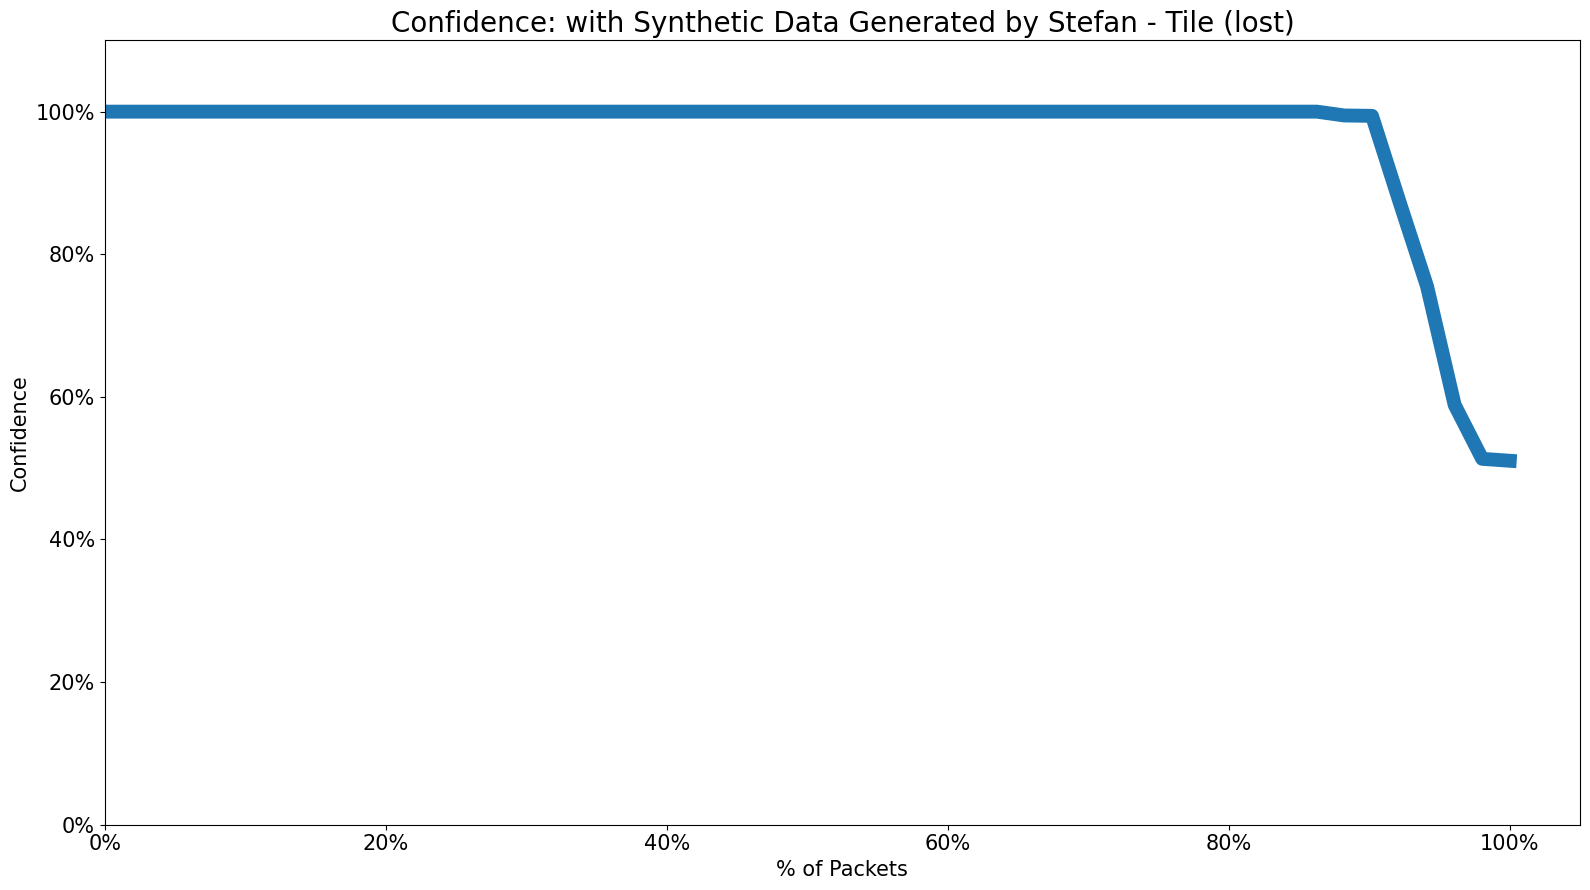

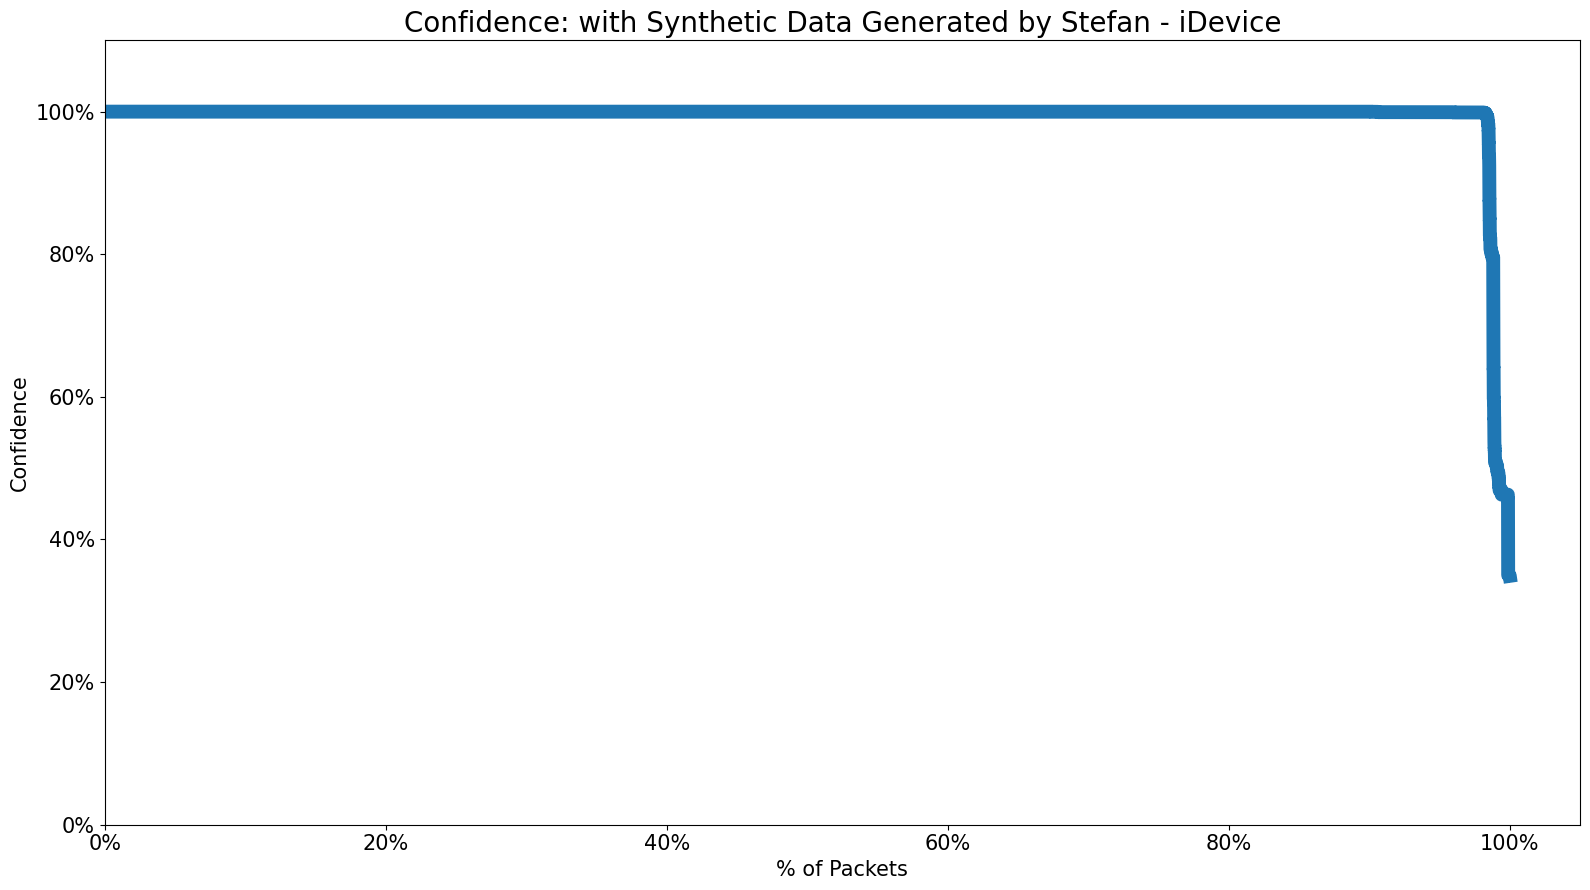

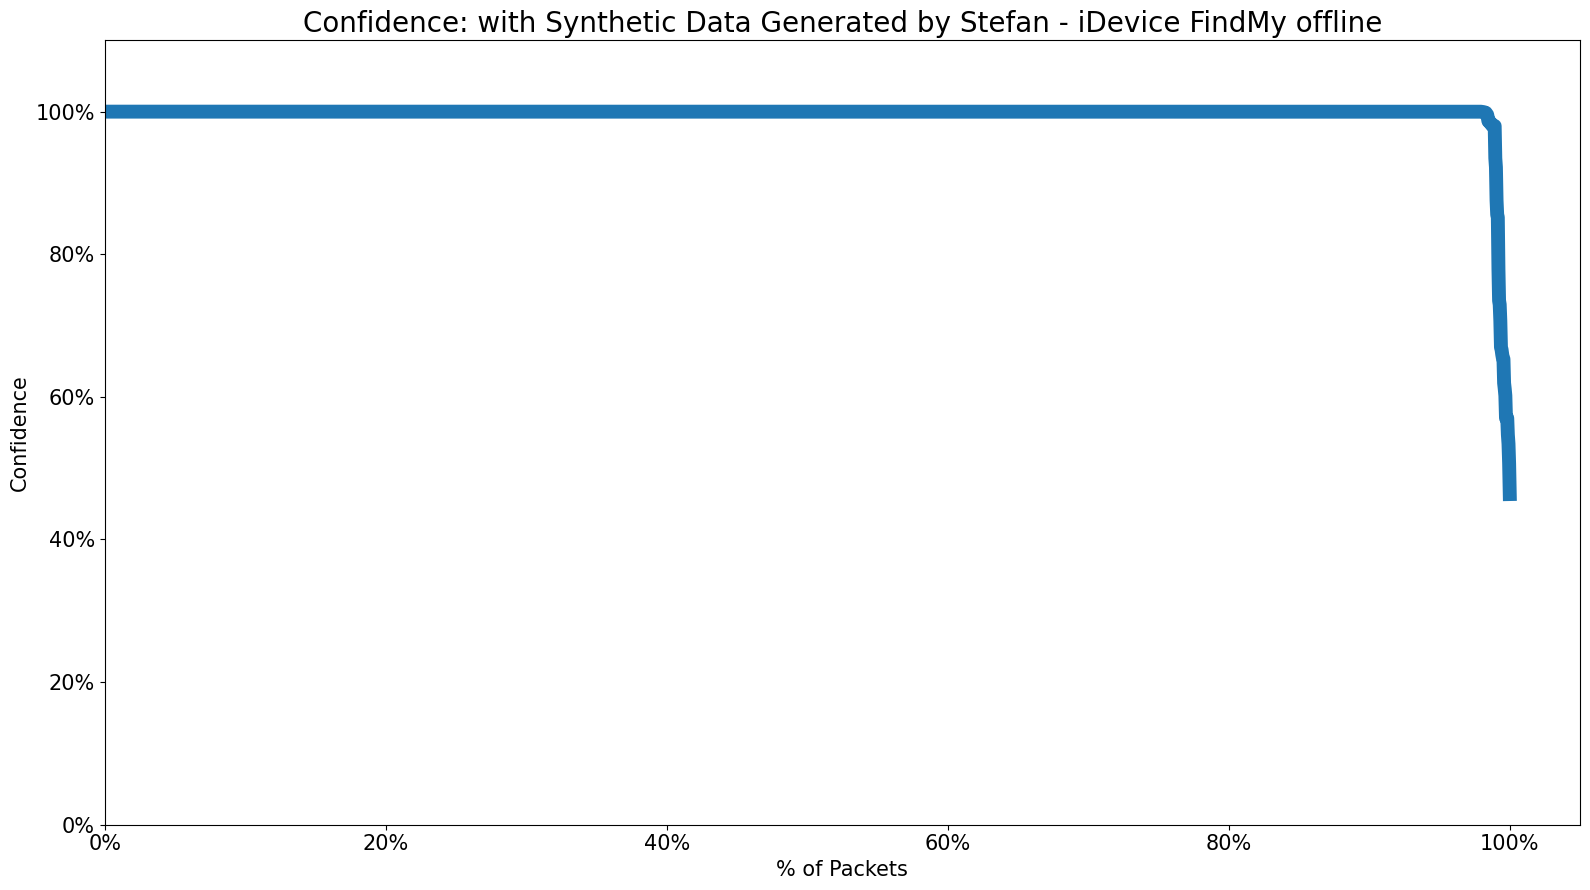

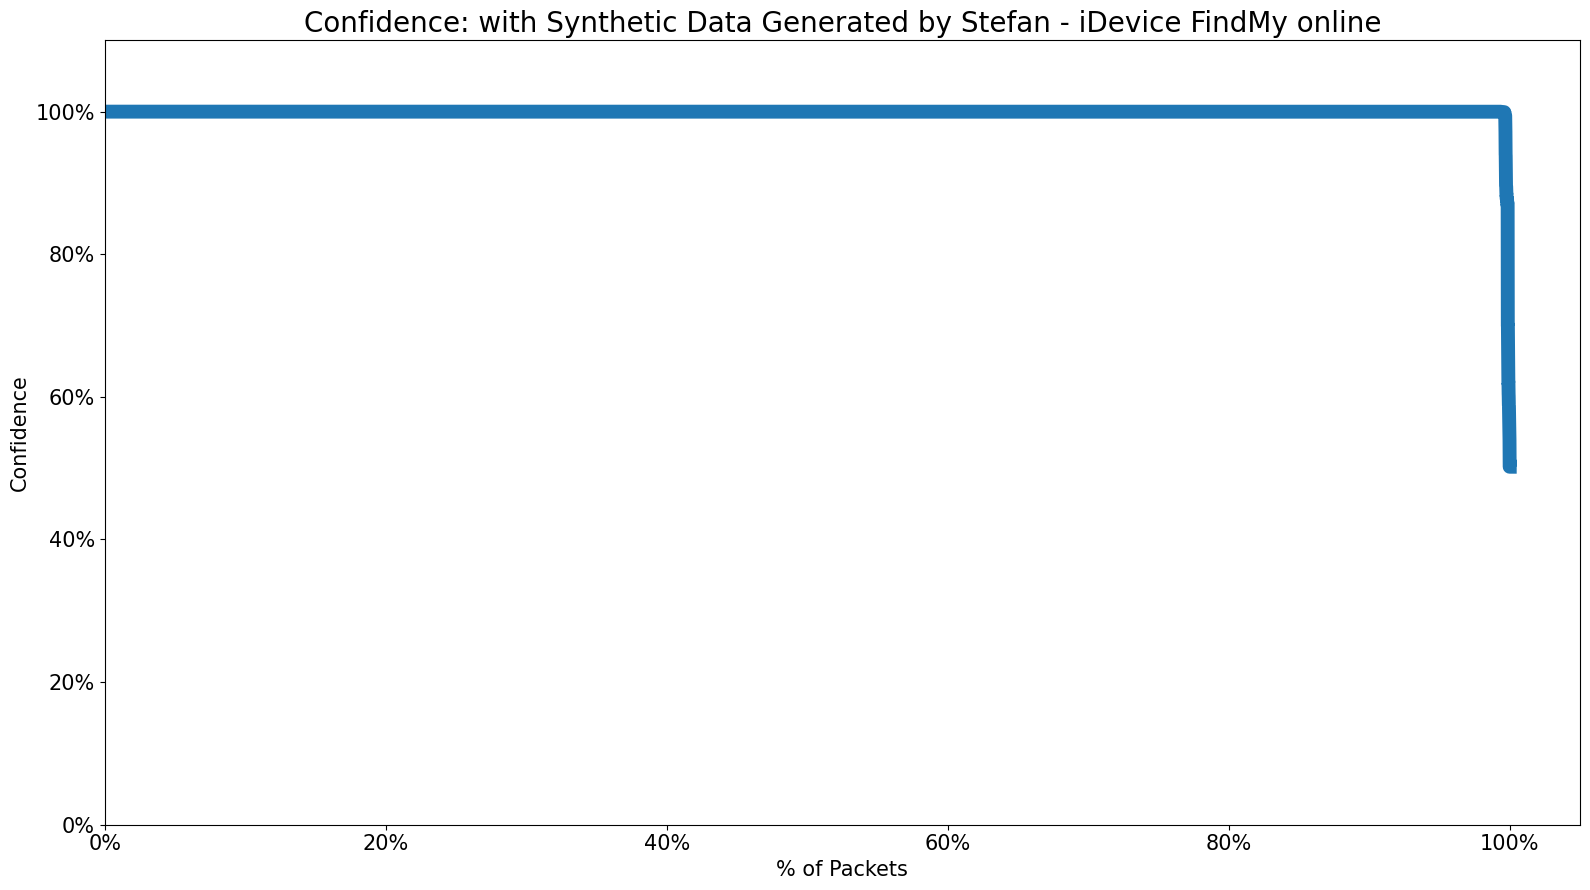

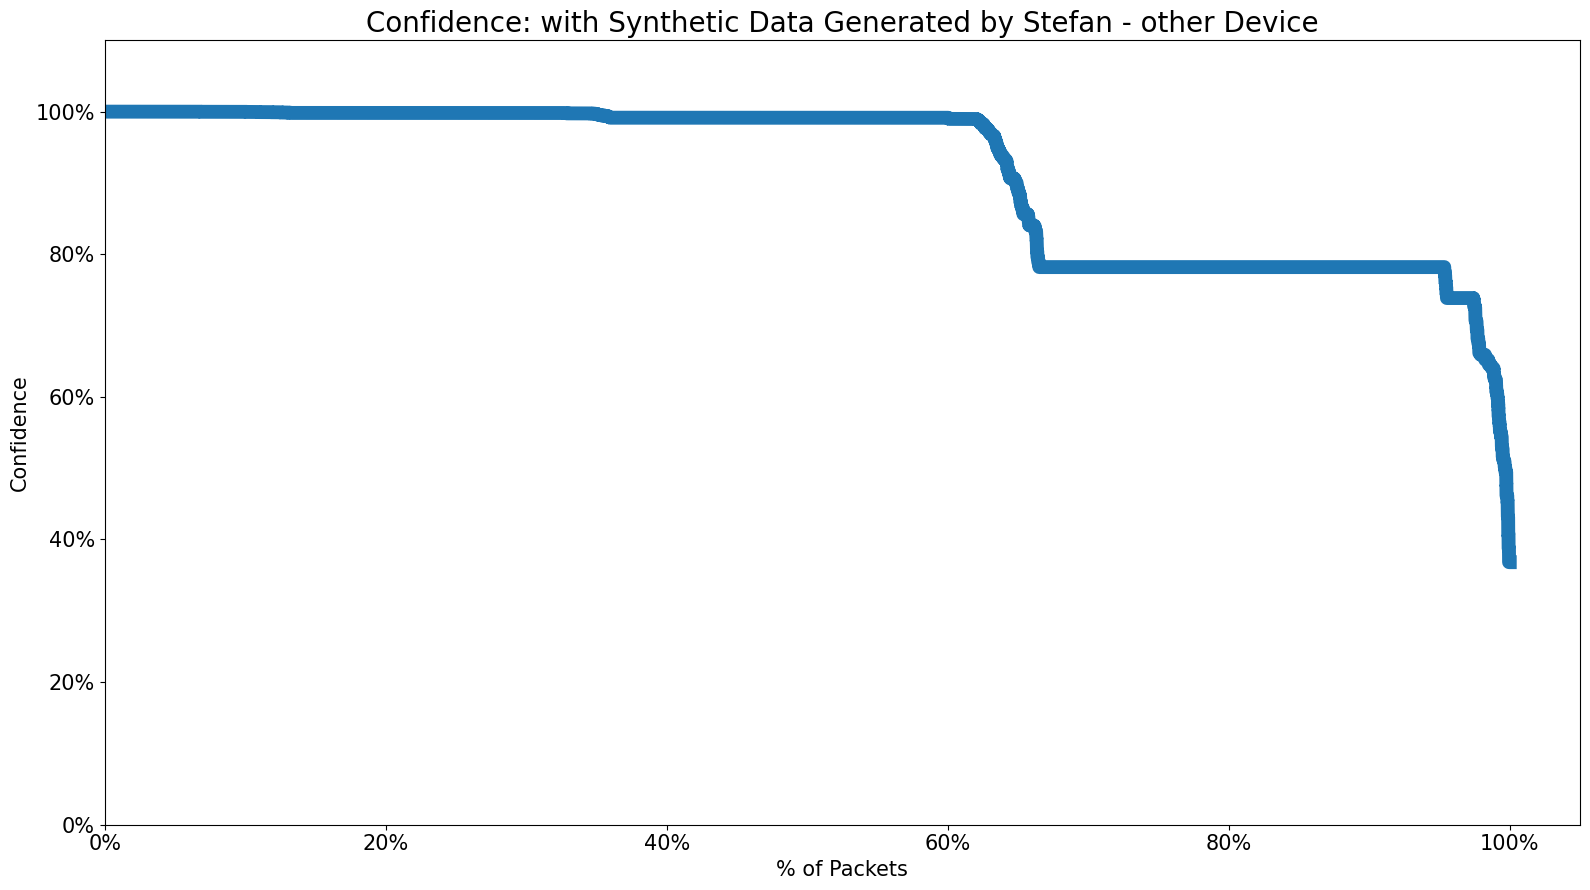

""


In [24]:
y_pred.groupby('Label').apply(plotLorenz)

In [11]:
y_pred

,Source,Time,FindMy Tracker (lost),FindMy Tracker (nearby),FindMy Tracker (unpaired),SmartTag (lost),SmartTag (nearby),Tile (lost),iDevice,iDevice FindMy offline,iDevice FindMy online,other Device,Label,Max Proba
0,d5:b6:19:29:fb:2a,2024-04-25 15:42:32.297384024,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,100.00,0.00,iDevice FindMy online,100.00
1,d5:b6:19:29:fb:2a,2024-04-25 15:42:32.298383951,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,100.00,0.00,iDevice FindMy online,100.00
2,d5:b6:19:29:fb:2a,2024-04-25 15:42:32.299381971,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,99.99,0.00,iDevice FindMy online,99.99
3,7a:2d:7c:6b:c0:82,2024-04-25 15:42:32.300105095,0.00,0.01,0.01,0.0,21.73,0.00,0.02,0.0,0.02,78.20,other Device,78.20
4,de:c0:00:81:de:a0,2024-04-25 15:42:32.303154945,0.07,1.31,0.04,0.0,0.91,0.01,0.01,0.0,0.00,97.66,other Device,97.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490026,44:0f:6b:64:be:6c,2024-04-25 16:12:34.853841066,0.00,0.00,0.01,0.0,0.00,0.00,99.99,0.0,0.00,0.00,iDevice,99.99
490027,7c:a1:e7:26:14:bd,2024-04-25 16:12:34.858575106,0.00,0.00,0.00,0.0,0.00,0.00,100.00,0.0,0.00,0.00,iDevice,100.00
490028,7c:a1:e7:26:14:bd,2024-04-25 16:12:34.859222889,0.00,0.00,0.00,0.0,0.00,0.00,100.00,0.0,0.00,0.00,iDevice,100.00
490029,6c:6b:0b:eb:e0:e8,2024-04-25 16:12:34.873466015,0.00,0.01,0.01,0.0,21.73,0.00,0.02,0.0,0.02,78.20,other Device,78.20


# Don't need to run following code for this research @Keisuke

In [12]:
temp = y_pred.copy(deep = True)

In [13]:
temp = temp.groupby(['Source', 'Label']).agg(Count = ('Label', 'count'), Probability = ('Max Proba', 'mean')).reset_index()

temp['Score'] = temp['Count'] * temp['Probability']
temp['Score'] = 100 *  temp['Score'] / temp.groupby(['Source'])['Score'].transform('sum')
temp = temp.round(2)
temp

,Source,Label,Count,Probability,Score
0,00:06:61:72:6d:c4,other Device,1,99.99,100.0
1,00:08:40:b8:80:cb,other Device,1,100.00,100.0
2,00:09:47:56:ba:d4,other Device,1,99.46,100.0
3,00:09:a7:4f:a5:20,other Device,1,99.95,100.0
4,00:09:a7:57:85:fd,other Device,216,97.84,100.0
...,...,...,...,...,...
30904,ff:f6:d6:7b:30:6d,other Device,2,99.81,100.0
30905,ff:fa:b0:c5:53:60,iDevice FindMy online,12,100.00,100.0
30906,ff:fa:b0:c5:53:62,iDevice FindMy online,1,99.99,100.0
30907,ff:ff:25:a5:57:72,FindMy Tracker (lost),13,80.87,91.4


In [14]:
devices = temp.loc[temp.groupby(['Source'])['Score'].idxmax()]
devices

,Source,Label,Count,Probability,Score
0,00:06:61:72:6d:c4,other Device,1,99.99,100.0
1,00:08:40:b8:80:cb,other Device,1,100.00,100.0
2,00:09:47:56:ba:d4,other Device,1,99.46,100.0
3,00:09:a7:4f:a5:20,other Device,1,99.95,100.0
4,00:09:a7:57:85:fd,other Device,216,97.84,100.0
...,...,...,...,...,...
30903,ff:f4:73:8f:f6:4c,other Device,1,96.47,100.0
30904,ff:f6:d6:7b:30:6d,other Device,2,99.81,100.0
30905,ff:fa:b0:c5:53:60,iDevice FindMy online,12,100.00,100.0
30906,ff:fa:b0:c5:53:62,iDevice FindMy online,1,99.99,100.0


In [15]:
threshold = 0
devices = devices[devices['Probability'] > threshold]

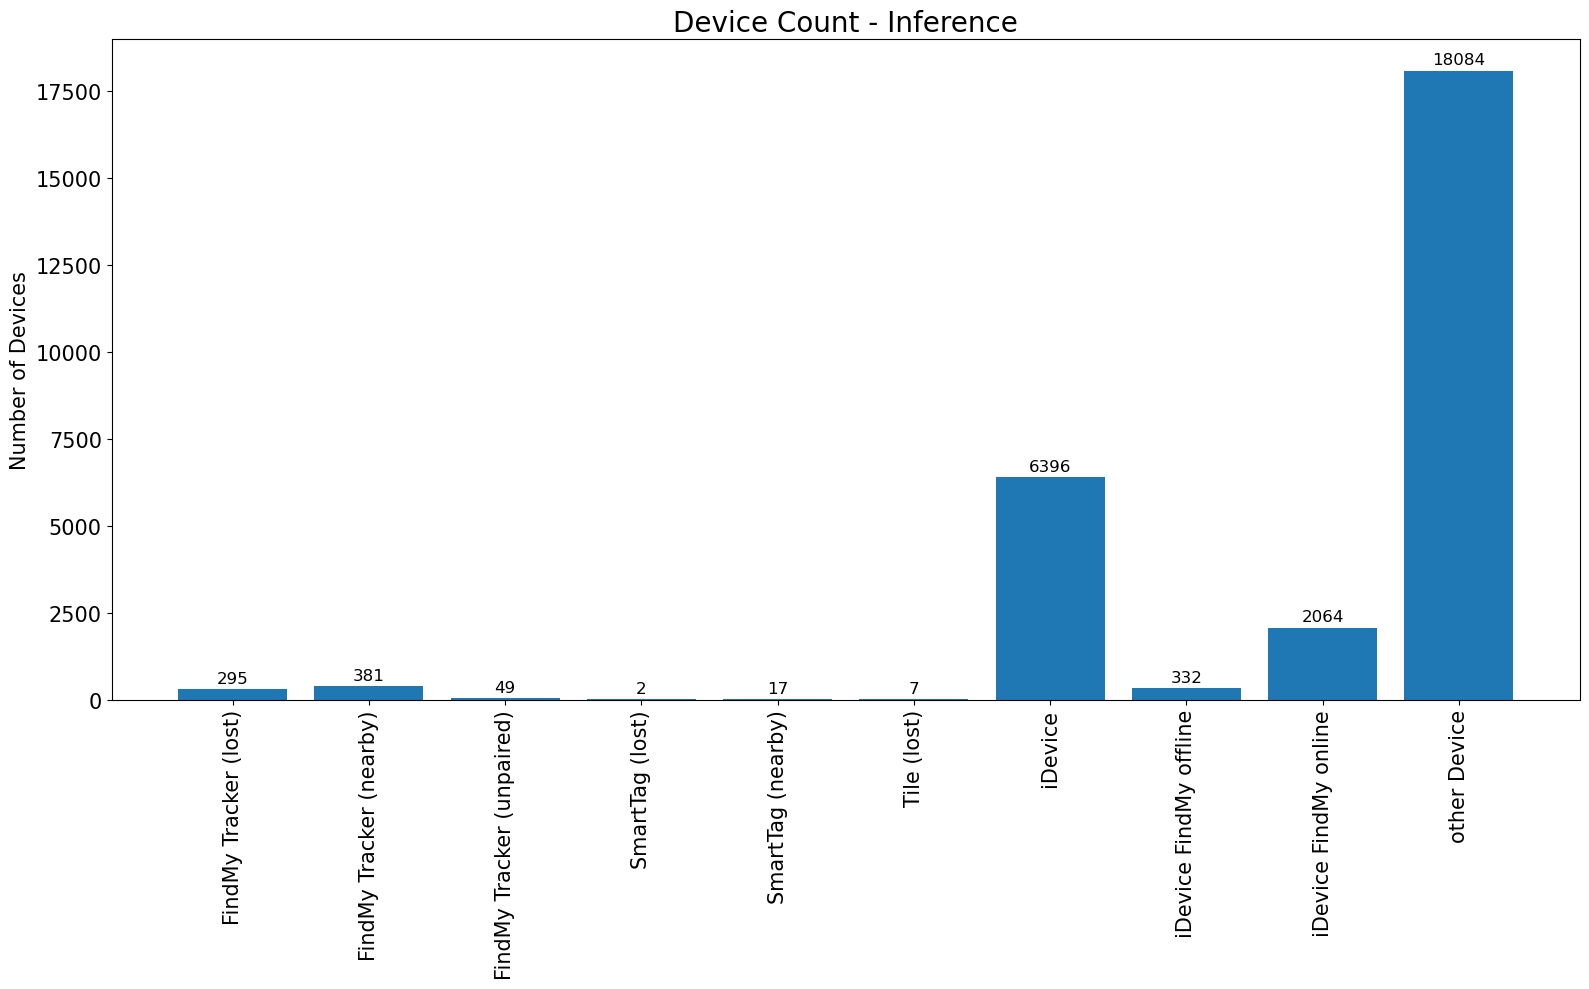

In [16]:
deviceCounts = devices.groupby('Label').size().reset_index().rename(columns = {0:'Count'})

x = deviceCounts['Label']
y = deviceCounts['Count']

title = "Device Count - Inference"
plt.figure(figsize=(16, 10), dpi = 100),
plt.bar(x, y)

offset = y.max() * 0.01
for i in range(len(x)):
    plt.text(i, y[i] + offset, np.round(y[i]), ha='center', fontsize = 12)
        
plt.ylabel("Number of Devices", fontsize=15)
plt.xticks(rotation = 90, fontsize=15)
plt.yticks(fontsize=15)
plt.title(title, fontsize = 20)
plt.tight_layout()
#plt.savefig(plotPath + title + '.png', dpi = 300)
plt.show()

In [17]:
print(round(devices['Source'].nunique() * 100 / y_pred['Source'].nunique(),1),"%")

100.0 %


In [18]:
print(round(len(y_pred.merge(devices, on = ['Source'], how = 'inner')) / len(y_pred) * 100,1), '%')

100.0 %


In [19]:
InferencePipeline = ModelingPipeline[0]
InferencePipeline.print(priority = True, flags = True)

10 Pre Processing: Pre Processing
	10 Select and order columns
	20 Company ID and UUID
		10 Fill Company ID with None
		20 Fill UUID with None
		30 Replace Company IDs
		40 Replace Company UUIDs
	30 MS Data Processing
		10 Fill MS Data with empty String
		20 Length of MS Data
		30 Continuity Type
		40 Drop MS Data Column
	40 Service Data Processing
		10 Fill Service Data with empty String
		20 Length of Service Data
		30 Samsung Type
		40 Drop Service Data Column
	50 Fill Numeric NA with 0
	60 Fill String NA with None
	70 Datetime conversion
	80 Clean PDU
	90 Order DataFrame
	100 Convert object type to string


In [20]:
def getPlotPipeline(titleSuffix: str, labelColumn: str = 'Label', show: bool = True, savePath: str = None, mode:str='inference'):
    return PlotPipelineFactory(titleSuffix=titleSuffix, labelColumn=labelColumn, show=show, savePath=savePath, mode = mode)

def filesToPlottingDataFrame(filesList: list[str], filePath: str = dataPath, dropLabels:list[str]=None, deviceTable = devices, labelColumn = 'Label', 
                             config: AbstractTask = InferencePipeline) -> pd.DataFrame:
    if dropLabels is None:
        dropLabels = []
    dataset = pd.DataFrame()

    for index, f in enumerate(filesList):
        myPipeline = Pipeline().setPath(filePath + f).loadData()

        new_dataset = myPipeline.setTask(config).run()
        new_dataset['File'] = 'File ' + str(index+1)
        
        dataset = pd.concat([dataset, new_dataset])
    
    dataset = dataset.merge(deviceTable, on = ['Source'], how = 'inner')
    
    for label in dropLabels:
            dataset = dataset[~dataset[labelColumn].str.contains(label)]

    dataset = dataset[~dataset[labelColumn].isin(dropLabels)]

    dataset.reset_index(drop = True, inplace = True)

    return dataset

In [21]:
files = ["Inference\Bahnhof_V2.csv",
         ]

data = filesToPlottingDataFrame(files)

plotPipeline = getPlotPipeline('Inference with synthetic Data')
data = plotPipeline.execute(data)

FileNotFoundError: [Errno 2] No such file or directory: '../data/csv/Inference\\Bahnhof_V2.csv'